In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from scipy import stats
from scipy.stats import pearsonr, spearmanr
from math import sqrt

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score
from sklearn.tree import export_graphviz
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import f_regression 
import sklearn.preprocessing
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures

import graphviz
from graphviz import Graph

import env
import wrangle
import os

# turn off pink boxes for demo
import warnings
warnings.filterwarnings("ignore")

In [2]:
# use function to pull in, clean, split, and scale zillow data
train, validate, test, train_scaled, validate_scaled, test_scaled = wrangle.wrangle_zillow()
train.shape, validate.shape, test.shape, train_scaled.shape, validate_scaled.shape, test_scaled.shape

((8288, 9), (3552, 9), (2960, 9), (8288, 9), (3552, 9), (2960, 9))

In [4]:
# review data
train.head()

,bathrooms,bedrooms,area,lot_area,taxvalue,age,los_angeles,orange,ventura
50816,3.0,3,2612,6907.0,562338,14,1,0,0
31475,2.0,3,1374,6004.0,449420,70,1,0,0
36038,2.0,4,1310,4714.0,470000,45,0,0,1
36117,2.0,3,1095,6300.0,419390,66,0,1,0
13937,2.0,3,1294,6377.0,428000,71,1,0,0


In [7]:
# create a function that creates a row with observation's county
def add_county_column(row):
    if row['los_angeles'] == 1:
        return 'Los Angeles'
    elif row['orange'] == 1:
        return 'Orange'
    elif row['ventura'] == 1:
        return 'Ventura'

train['county'] = train.apply(lambda row: add_county_column(row), axis = 1)
train.head()

,bathrooms,bedrooms,area,lot_area,taxvalue,age,los_angeles,orange,ventura,county
50816,3.0,3,2612,6907.0,562338,14,1,0,0,Los Angeles
31475,2.0,3,1374,6004.0,449420,70,1,0,0,Los Angeles
36038,2.0,4,1310,4714.0,470000,45,0,0,1,Ventura
36117,2.0,3,1095,6300.0,419390,66,0,1,0,Orange
13937,2.0,3,1294,6377.0,428000,71,1,0,0,Los Angeles


In [ ]:
# drop columns to focus only on area, bedrooms, and bathrooms for initial exploration
# train = train_full.drop(columns = ['lot_area', 'yearbuilt','age','Los Angeles, CA','Orange, CA','Ventura, CA'])
# validate = validate_full.drop(columns = ['lot_area', 'yearbuilt','age','Los Angeles, CA','Orange, CA','Ventura, CA'])
# test = test_full.drop(columns = ['lot_area', 'yearbuilt','age','Los Angeles, CA','Orange, CA','Ventura, CA'])
# train_scaled = train_scaled_full.drop(columns = ['lot_area', 'yearbuilt','age','Los Angeles, CA','Orange, CA','Ventura, CA'])
# validate_scaled = validate_scaled_full.drop(columns = ['lot_area', 'yearbuilt','age','Los Angeles, CA','Orange, CA','Ventura, CA'])
# test_scaled = test_scaled_full.drop(columns = ['lot_area', 'yearbuilt','age','Los Angeles, CA','Orange, CA','Ventura, CA'])

# Exploration

### What are some of the drivers of property tax value?

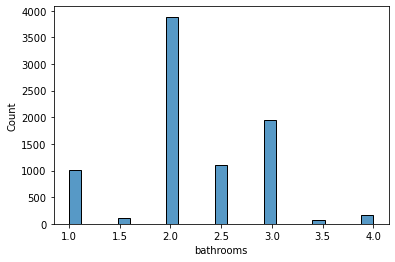

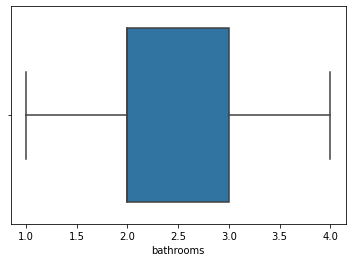

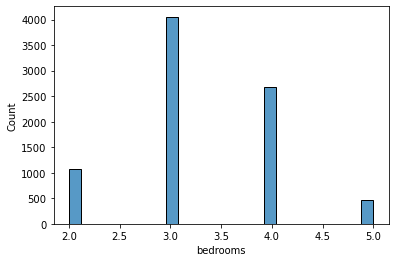

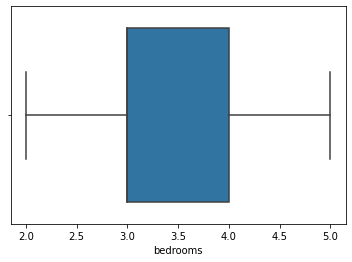

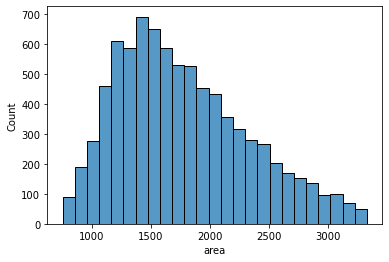

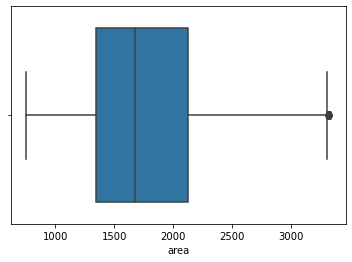

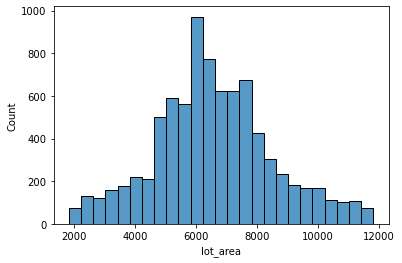

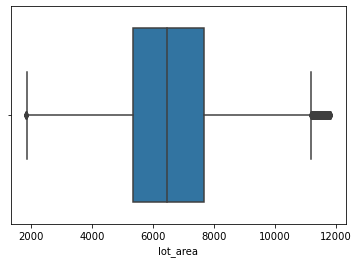

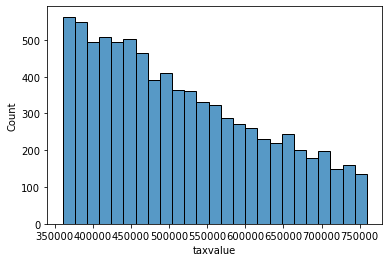

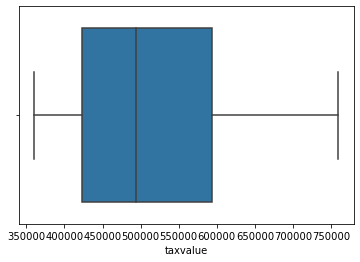

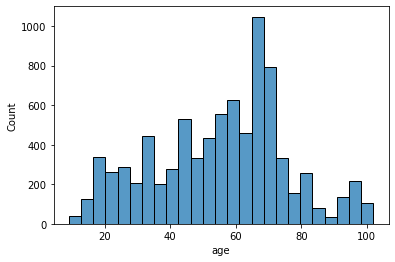

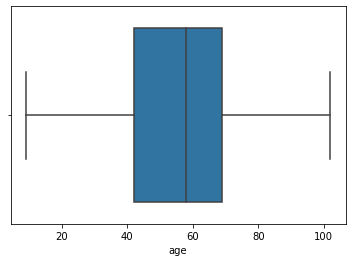

In [17]:
num_cols = [col for col in train if col not in ['los_angeles','orange','ventura','county']]
for col in num_cols:
    sns.histplot(train[col], log_scale=[False,False], bins=25)
    plt.show()
    sns.boxplot(train[col])
    plt.show()

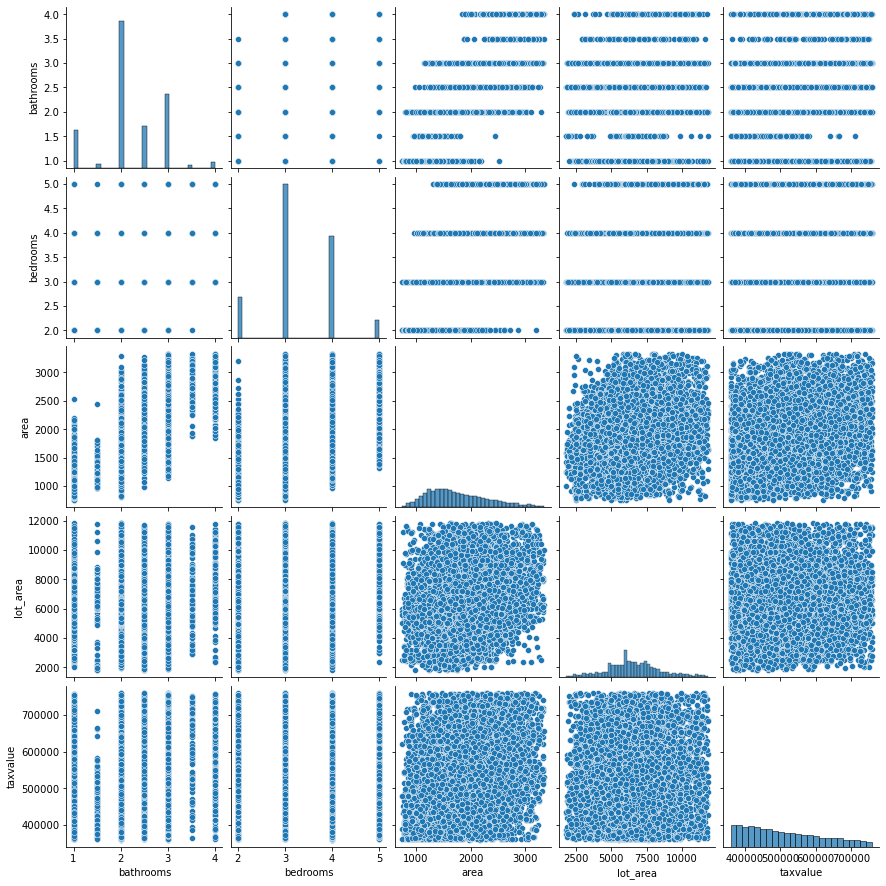

In [11]:
subset = train.iloc[:,:5]
sns.pairplot(subset)

## Does location affect property tax value?

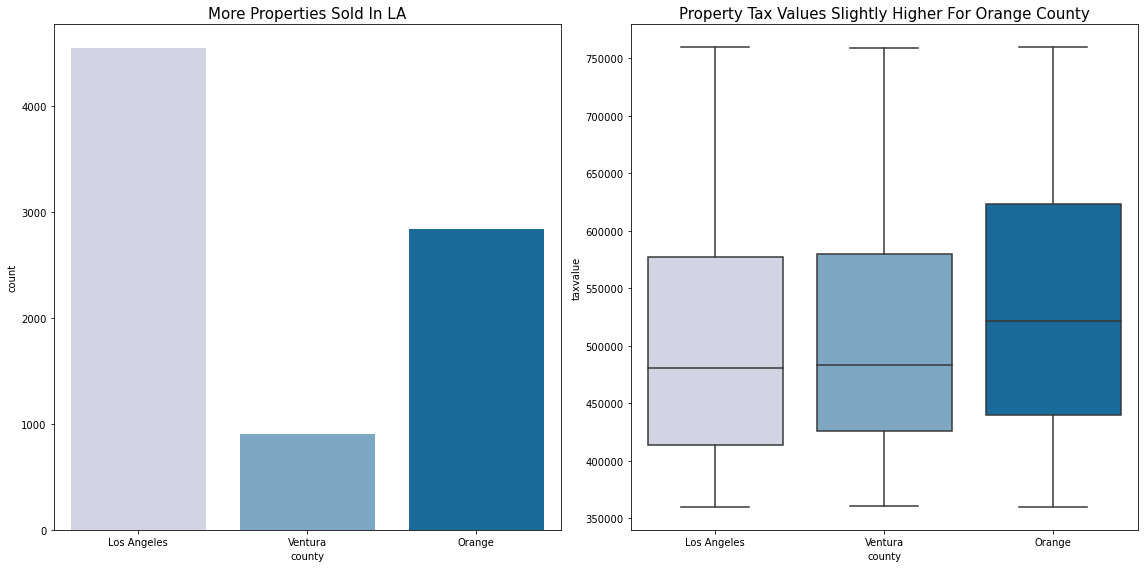

In [37]:
plt.figure(figsize=(16,8))

plt.subplot(1,2,1)
sns.countplot(x='county', palette='PuBu', data=train)
plt.title('More Properties Sold In LA', fontsize=15)

plt.subplot(1,2,2)
sns.boxplot(x='county', y='taxvalue', data=train , palette='PuBu')
plt.title('Property Tax Values Slightly Higher For Orange County', fontsize=15)

plt.tight_layout()

## Does number of bedrooms affect property tax value?

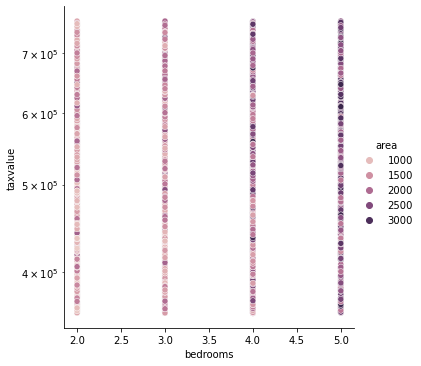

In [38]:
ax = sns.relplot(x='bedrooms', y='taxvalue', data=train, kind='scatter', hue='area')
ax.set(yscale='log')
# plt.ticklabel_format(style='plain', axis='y')

**Hypothesis testing using Pearson's r to see if this is statistically significant since chart is not very clear:**

**Null Hypothesis: There is no linear relationship between number of bedrooms and the tax value of a property**

**Alternate Hypothesis: There is a linear relationship between number of bedrooms and the tax value of a property**

In [39]:
alpha = 0.05

r, p_value = pearsonr(train.bedrooms, train.taxvalue)

if p_value > alpha:
    print('We fail to reject the null hypothesis')
else:
    print('We reject the null hypothesis')
print(f'p-value: {round(p_value,3)}')

We reject the null hypothesis
p-value: 0.0


## Does number of bathrooms affect property tax value?

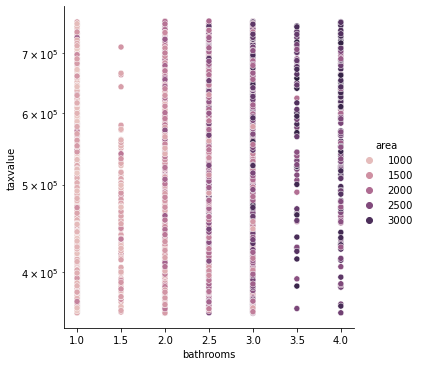

In [40]:
ax2 = sns.relplot(x='bathrooms', y='taxvalue', data=train, kind='scatter', hue='area')
ax2.set(yscale='log')
# plt.ticklabel_format(style='plain', axis='y')

**Hypothesis testing using Pearson's r to see if this is statistically significant since chart is not very clear:**

**Null Hypothesis: There is no linear relationship between number of bathrooms and the tax value of a property**

**Alternate Hypothesis: There is a linear relationship between number of bathrooms and the tax value of a property**

In [105]:
alpha = 0.05

r, p_value = pearsonr(train.bathrooms, train.taxvalue)

if p_value > alpha:
    print('We fail to reject the null hypothesis')
else:
    print('We reject the null hypothesis')
print(f'p-value: {round(p_value,3)}')

We reject the null hypothesis
p-value: 0.0


## What features do have the highest correlation with property tax value?

<AxesSubplot:>

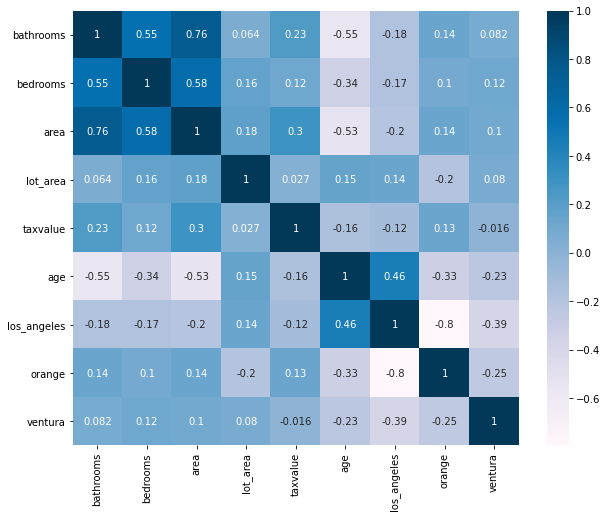

In [52]:

plt.figure(figsize=(10, 8))
cmap = sns.cubehelix_palette()
sns.heatmap(train.corr(), cmap='PuBu', annot=True)

# Modeling

In [107]:
# create X and y version of train, validate, and test
X_train = train_scaled.drop(columns=['lot_area','taxvalue','age','los_angeles','orange','ventura'])
y_train = pd.DataFrame(train.taxvalue)

X_validate = validate_scaled.drop(columns=['lot_area','taxvalue','age','los_angeles','orange','ventura'])
y_validate = pd.DataFrame(validate.taxvalue)

X_test = test_scaled.drop(columns=['lot_area','taxvalue','age','los_angeles','orange','ventura'])
y_test = pd.DataFrame(test.taxvalue)

In [108]:
X_train.head()

,bathrooms,bedrooms,area
0,1.173690,-0.403961,1.516242
1,-0.336329,-0.403961,-0.719296
2,-0.336329,0.901823,-0.834865
3,-0.336329,-0.403961,-1.223104
4,-0.336329,-0.403961,-0.863757


In [109]:
# establish a baseline for predicted tax value using median which is common for housing values
y_train['baseline'] = train.taxvalue.median()
y_validate['baseline'] = train.taxvalue.median()

In [110]:
# calculate baseline rmse for train and validate
baseline_rmse_train = mean_squared_error(y_train.taxvalue, y_train.baseline)**(1/2)
baseline_rmse_validate = mean_squared_error(y_validate.taxvalue, y_validate.baseline)**(1/2)

print("RMSE using Median\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))

RMSE using Median
Train/In-Sample:  100883.58 
Validate/Out-of-Sample:  100623.41


In [85]:
# create the Linear Regression model object
lm = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm.fit(X_train, y_train.taxvalue)

# predict train
y_train['pred_lm'] = lm.predict(X_train)

# evaluate: rmse
lm_rmse_train = mean_squared_error(y_train.taxvalue, y_train.pred_lm)**(1/2)

# predict validate
y_validate['pred_lm'] = lm.predict(X_validate)

# evaluate: rmse
lm_rmse_validate = mean_squared_error(y_validate.taxvalue, y_validate.pred_lm)**(1/2)

print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", lm_rmse_train, 
      "\nValidation/Out-of-Sample: ", lm_rmse_validate)

RMSE for OLS using LinearRegression
Training/In-Sample:  102387.81235420196 
Validation/Out-of-Sample:  100821.95686884897


In [86]:
# create the LassoLars model object
lars = LassoLars(alpha=1.5)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lars.fit(X_train, y_train.taxvalue)

# predict train
y_train['pred_lars'] = lars.predict(X_train)

# evaluate: rmse
lars_rmse_train = mean_squared_error(y_train.taxvalue, y_train.pred_lars)**(1/2)

# predict validate
y_validate['pred_lars'] = lars.predict(X_validate)

# evaluate: rmse
lars_rmse_validate = mean_squared_error(y_validate.taxvalue, y_validate.pred_lars)**(1/2)

print("RMSE for Lasso + Lars\nTraining/In-Sample: ", lars_rmse_train, 
      "\nValidation/Out-of-Sample: ", lars_rmse_validate)

RMSE for Lasso + Lars
Training/In-Sample:  102388.30494578095 
Validation/Out-of-Sample:  100826.83434543133


In [87]:
# create the Generalized Linear model object
glm = TweedieRegressor(power=1, alpha=1.1)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
glm.fit(X_train, y_train.taxvalue)

# predict train
y_train['pred_glm'] = glm.predict(X_train)

# evaluate: rmse
glm_rmse_train = mean_squared_error(y_train.taxvalue, y_train.pred_glm)**(1/2)

# predict validate
y_validate['pred_glm'] = glm.predict(X_validate)

# evaluate: rmse
glm_rmse_validate = mean_squared_error(y_validate.taxvalue, y_validate.pred_glm)**(1/2)

print("RMSE for GLM using Tweedie, power=1 & alpha=1.1\nTraining/In-Sample: ", glm_rmse_train, 
      "\nValidation/Out-of-Sample: ", glm_rmse_validate)

RMSE for GLM using Tweedie, power=1 & alpha=1.1
Training/In-Sample:  102487.43339245612 
Validation/Out-of-Sample:  100902.7278754331


In [88]:
# create new features for train, validate, and test based on value indicated for use with Polynomial Regression model
pf = PolynomialFeatures(degree=2)

# fit and transform X_train
X_train_degree2 = pf.fit_transform(X_train)

# transform X_validate & X_test
X_validate_degree2 = pf.transform(X_validate)
X_test_degree2 = pf.transform(X_test)

In [89]:
# create the Polynomial Regression model object
lm2 = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm2.fit(X_train_degree2, y_train.taxvalue)

# predict train
y_train['pred_lm2'] = lm2.predict(X_train_degree2)

# evaluate: rmse
pr_rmse_train = mean_squared_error(y_train.taxvalue, y_train.pred_lm2)**(1/2)

# predict validate
y_validate['pred_lm2'] = lm2.predict(X_validate_degree2)

# evaluate: rmse
pr_rmse_validate = mean_squared_error(y_validate.taxvalue, y_validate.pred_lm2)**(1/2)

print("RMSE for Polynomial Model, degrees=2\nTraining/In-Sample: ", pr_rmse_train, 
      "\nValidation/Out-of-Sample: ", pr_rmse_validate)

RMSE for Polynomial Model, degrees=2
Training/In-Sample:  102037.82621528127 
Validation/Out-of-Sample:  100623.40885693024


In [95]:
# use best model to predict test
y_test['baseline'] = train.taxvalue.median()

baseline_rmse_test = mean_squared_error(y_test.taxvalue, y_test.baseline)**(1/2)

print("RMSE using Median\nTest/Out-of-Sample: ", round(baseline_rmse_test, 2))

RMSE using Median
Test/Out-of-Sample:  108982.02
